In [1]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import transform

from shapely.geometry import Point, Polygon
import datetime

from io import StringIO
from pathlib import Path, PureWindowsPath
import os
import sys
from functools import partial

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location
from scripts.summary_stats import summary_stats

data_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets/")
shape_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Shared 228 Sydney Folder/SA2 Shapefiles/")
dv_analysis_path =  Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Shared 228 Sydney Folder/AU Work/MasterTypologyFolder")
sa2_w_dv = pd.read_csv(dv_analysis_path/'dummies_t3_corridor.csv')

Wall time: 1.07 s


In [2]:
def filter_and_home_assign(data, shapefile, lower, upper):
    """
    Find subset of data to analyze based on lower/upper bounds on tweets/user, 
    then add home locations.
    
    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id
    
    shapefile : gpd.GeoDataFrame
        Shapefile for tracts in tweets location.
        Must be in WGS84 (epsg:4326) format (to align with tweet lat/lon).
    
    lower, upper : int or float
        Lower (inclusive) and upper (exclusive) bounds on tweets/user.
        
    Returns
    -------
    filtered : gpd.GeoDataFrame
        Collection of tweets filtered by lower/upper and with tweet geographies.
        Contains new columns:
            - 'timestamp' : pd.Timestamp for time of tweet published
            - 'date' : date (int) of tweet published
            - 'hour' : 24-hour (int) of tweet published
            - 'home' : name of home location codigo (some may be NaN)
            - 'is_home' : boolean indicating whether tweet was made at home
    """
    # Filter based on lower and upper bound on tweets/user
    filtered = data.groupby('u_id').filter(lambda group: (len(group) >= lower) & (len(group) < upper))
    
    # Geometrize tweets (inplace) based on lat/lon
    filtered = geometrize_tweets(filtered)
    
    # Spatial join with tracts
    filtered = gpd.sjoin(filtered, shapefile, how='left', op='intersects')
    
    # Add datetime
    filtered['timestamp'] = pd.to_datetime(filtered['created_at'] // 1000, unit='s')
    filtered['date'] = filtered['timestamp'].dt.date
    filtered['hour'] = filtered['timestamp'].dt.hour
    
    # Add home location
    filtered['home'] = assign_home_location(filtered, SA2='SA2_MAIN16')
    filtered['is_home'] = filtered['SA2_MAIN16'] == filtered['home']
    
    return filtered

In [3]:
tweets_2012 = pd.read_csv(data_path/'AUST_TWT_2012.csv')
tweets_2012.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
# Read Australia SA2 shapefiles sa2_ucl
syd_ucl_sa2 = gpd.read_file(shape_path/'sa2_ucl.dbf')
# We also need to change the crs 
syd_ucl_sa2.crs = {'init': 'epsg:4326'}
# change the sa2_main16 ID to int
syd_ucl_sa2['SA2_MAIN16'] = syd_ucl_sa2['SA2_MAIN16'].astype(int)
# do the same for the case study area DVs
sa2_w_dv['SA2_MAIN16'] = sa2_w_dv['SA2_MAIN16'].astype(int)
# merge the two dataframes
syd_ucl_sa2 = pd.merge(syd_ucl_sa2, sa2_w_dv, how='left', on='SA2_MAIN16')
#drop variables
syd_ucl_sa2.drop('Unnamed: 0',axis=1,inplace=True)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
tweets_2012.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,timestamp,date
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),2012-07-23 14:31:39,2012-07-23 00:00:00
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872),2012-07-23 13:29:28,2012-07-23 00:00:00
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),2012-07-23 13:31:39,2012-07-23 00:00:00
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),2012-07-23 13:38:57,2012-07-23 00:00:00
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),2012-07-23 13:41:42,2012-07-23 00:00:00


## Filtering data and adding tracts

First, we want to filter the data to exclude rare Twitter users (tweet count below median number of tweets/user) and power users (tweet count above 99th percentile of tweets/user). Methodology is as follows:

1. Compute 50th and 99th percentile of tweets/user
1. Select the subset of tweets made by users falling between those bounds
1. Geometrize tweet data by using lat/lon
1. Compute a spatial join between tweets and the tract shapefiles
1. Add datetime information for home location analysis
1. Assign home locations (home column) and whether or not tweet is made from home (is_home column)

In [6]:
pct_50, pct_99 = summary_stats(tweets_2012)

695571 total tweets
24391 unique users

Median number of tweets/user: 4.0 tweets
99th percentile of tweets/user: 393.1999999999971 tweets


In [7]:
twt2012 = filter_and_home_assign(tweets_2012, syd_ucl_sa2, pct_50, pct_99)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
twt2012.drop(['u_name','u_description','u_followers_count','u_screen_name','u_friends_count','location.lon',
             'location.lat','SA3_CODE16','SA3_NAME16','GCC_CODE16','GCC_NAME16','STE_CODE16','STE_NAME16'],
            axis=1,
            inplace=True)

## Analysis 

Before we begin our analysis, it helps to show a visual analysis of where our tweets are located. In the map below, we differentiate between the tweets that are assigned a tract (`SA2_MAIN16`) in our spatial join:

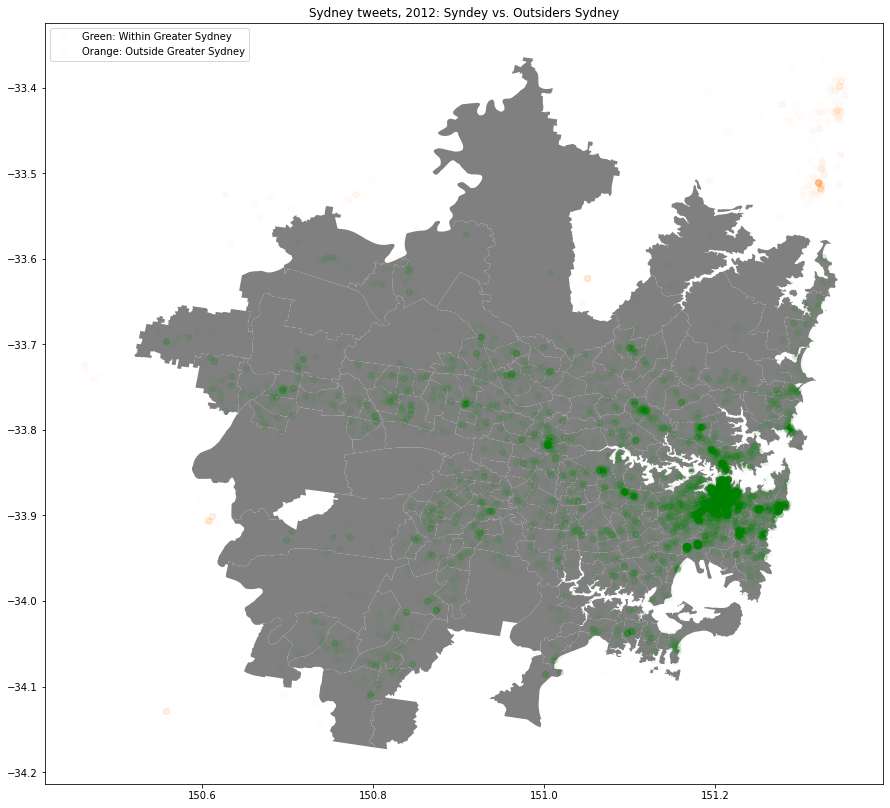

In [9]:
### Plot all 2012 tweets ###
# Green tweets: Joined to an SA2
# Orange tweets: No SA2 Assigned
# Gray: Australia shapefile

fig, ax = plt.subplots(figsize=(20, 14))
syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')
sample = twt2012.sample(frac=.05, random_state=42)
sample[~sample['SA2_MAIN16'].isnull()].plot(ax=ax, marker='o', color='green', alpha=0.01, label='Green: Within Greater Sydney')
sample[sample['SA2_MAIN16'].isnull()].plot(ax=ax, marker='o', color='orange', alpha=0.01, label='Orange: Outside Greater Sydney')
plt.legend()
plt.title('Sydney tweets, 2012: Syndey vs. Outsiders Sydney');

From this, we see that we can use [~autwt_2012['SA2_5DIG16'].isnull()] as a filter to select just the tweets in Syndey, which is our area of interest. For all following analyses, we will restrict the population to just the tweets that fall inside Sydney depicted by the shapefile.

Our first summary statistic computes the ratio of tweets that have a home assignment.

In [10]:
num_home_assigned_tweets = (~twt2012.loc[~twt2012['SA2_MAIN16'].isnull(), 'home'].isnull()).sum()
n_tweets = len(twt2012[~twt2012['SA2_MAIN16'].isnull()])

print("{}/{} = {:.2%} of tweets have a home assignment.".format(
    num_home_assigned_tweets, n_tweets, num_home_assigned_tweets / n_tweets
))

272795/450964 = 60.49% of tweets have a home assignment.


Next, we are interested in the ratio of users that have a home assignment.

In [11]:
num_users_with_home = (~twt2012.loc[~twt2012['SA2_MAIN16'].isnull()].groupby('u_id')['home'].first().isnull()).sum()
n_users = len(twt2012[~twt2012['SA2_MAIN16'].isnull()].groupby('u_id'))

print("{}/{} = {:.2%} of users have a home assignment.".format(
    num_users_with_home, n_users, num_users_with_home / n_users
))

2560/13261 = 19.30% of users have a home assignment.


Lastly, we want to know the ratio of tweets that were made from home (i.e. SA2_5DIG16 and home are equal).

In [12]:
num_tweets_from_home = twt2012.loc[~twt2012['SA2_MAIN16'].isnull(), 'is_home'].sum()

print("{}/{} = {:.2%} of tweets are posted from the home tract.".format(
    num_tweets_from_home, n_tweets, num_tweets_from_home / n_tweets
))

163030/450964 = 36.15% of tweets are posted from the home tract.


Our analysis concludes with a visual representation of this last information; namely, how are the tweets spread out across the entire metropolitan area of Sydney with respect to residence/nonresidence?

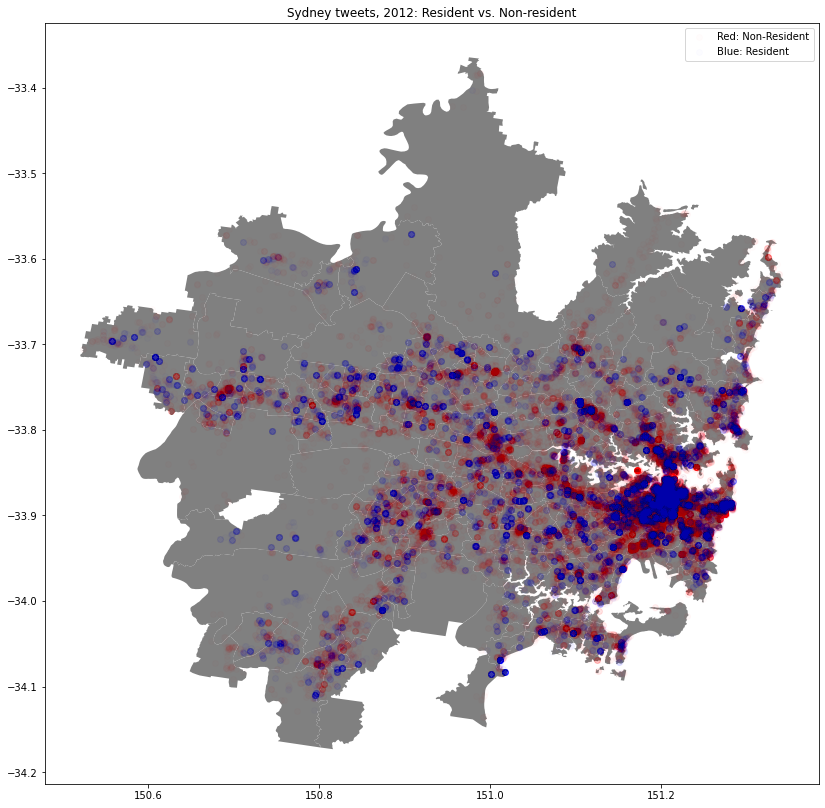

In [13]:
### Plot a 5% sample of 2012 tweets ###
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray: Sydney shapefile

fig, ax = plt.subplots(figsize=(20, 14))

syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

sample = twt2012[~twt2012['SA2_MAIN16'].isnull()].sample(frac=.25, random_state=42)

sample[~sample['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')

sample[sample['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')

plt.legend()
plt.title('Sydney tweets, 2012: Resident vs. Non-resident');

Our analysis concludes with a visual representation of this last information; namely, how are the tweets spread out across the entire metropolitan area of Sydney with respect to residence/nonresidence?

## Join with demographic data and Analyze Case Study Areas

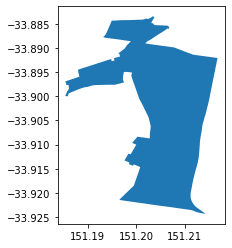

In [14]:
# Read in case study areas
# let's isolate the sa2s that make up our case study areas of Redfern/Waterloo, Merrickville and Maroubra
red_wat_gdf = syd_ucl_sa2[(syd_ucl_sa2.SA2_MAIN16==117031335)
                          |(syd_ucl_sa2.SA2_MAIN16==117031338)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
red_wat_simple = red_wat_gdf[['SA2_MAIN16','geometry', "SA4_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
red_wat_sgdf=red_wat_simple.dissolve(by="SA4_NAME16")
red_wat_sgdf.plot()

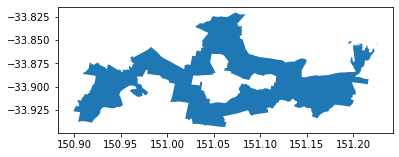

In [94]:
# let's isolate the sa2s that make up our case study areas of Redfern/Waterloo, Merrickville and Maroubra
t3_corr_gdf = syd_ucl_sa2[(syd_ucl_sa2.t3_corr_dv  ==1)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
t3_corr_simple = t3_corr_gdf[['SA2_MAIN16','geometry', "GCC_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
t3_corr_sgdf=t3_corr_simple.dissolve(by="GCC_NAME16")
t3_corr_sgdf.plot()

### Read in demographic data

The two most important variables that we're going to be looking at are educational attainment and income. Our research has used lower educated SA2s (

* **Low-Income:** Defined as SA2s where the percent of households with weekly income in the bottom two quintiles (bottom 40%) for the region exceeds the regional median SA2 percent in 2011 (41.4%). (The bottom 40% of weekly household income includes those earning below 1,250 per week (2011 Australian dollars).)
 * *The “bottom 40%” income bracket for 2011 includes the bottom 42.6% of households reporting weekly income, based on where the income ranges fall in the census*
 
 
* **Educational Attainment Delta:** The percent change in the percent of adults age 25 years and older whose highest educational attainment is a Bachelor degree or higher exceeds the regional median SA2 percent change from 2011 to 2016 (+11.6%)


* **Change in Professional Type:** The percent change in the percent of adults age 15 years and older whose occupation is Manager or Professional exceeds the regional median SA2 percent change from 2011 to 2016 (+3.4%). 

In [16]:
# read in data with SA2s and low-income tract dummy variables
low_inc = pd.read_csv(dv_analysis_path/'lowincomes.csv')
low_inc.drop(['Unnamed: 0','red_wat_dv','marrick_dv'],axis=1,inplace=True)

# read in data with SA2s and managerial profession delta dummy variables
prof_delta = pd.read_csv(dv_analysis_path/'managers.csv')
prof_delta.drop(['Unnamed: 0','red_wat_dv','marrick_dv'],axis=1,inplace=True)

# read in data with SA2s and managerial profession delta dummy variables
edu_delta = pd.read_csv(dv_analysis_path/'bachelors.csv')
edu_delta.drop(['Unnamed: 0','red_wat_dv','marrick_dv'],axis=1,inplace=True)

In [17]:
# merge twitter data with low-income indicator variables 
twt2012 = pd.merge(twt2012,low_inc,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

In [18]:
# merge twitter data with managerial indicator variables 
twt2012 = pd.merge(twt2012,prof_delta,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

In [19]:
# merge twitter data with managerial indicator variables 
twt2012 = pd.merge(twt2012,edu_delta,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

In [21]:
# remove unecessary variables
twt2012.drop(['SA2_MAINCODE_2016_x','SA2_MAINCODE_2016_y','SA2_MAINCODE_2016'],axis=1,inplace=True)

### Defining a user:

We now have information regarding if the user: 

* Has a home assigned to them 
* If they are from a tract that is low income 
* If they are from a highly educated tract 
* if they are from a tract with a high proportion of professionals

So now we need to create one more variable that combines all of these factors so that we can see where these people spend their time tweeting.

In [62]:
twt2012.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 458646 entries, 0 to 458645
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    458646 non-null  int64         
 1   created_at            458646 non-null  float64       
 2   text                  458646 non-null  object        
 3   u_id                  458646 non-null  int64         
 4   u_created_at          458646 non-null  float64       
 5   type                  458646 non-null  object        
 6   c_country             458646 non-null  object        
 7   geometry              458646 non-null  geometry      
 8   timestamp             458646 non-null  datetime64[ns]
 9   date                  458646 non-null  object        
 10  index_right           450964 non-null  float64       
 11  SA2_MAIN16            450964 non-null  float64       
 12  SA2_5DIG16            450964 non-null  object     

In [105]:
# create new indicator variable that shows privilege indicators above

twt2012['priv_nh_dv'] = np.where(((twt2012.home.notnull())# Where a tract has a home assignment
                              & (twt2012.is_home==0) # Where the tweet is not in their home tract
                              & (twt2012.lowinc_11_dv==0) # AND their tract is not low-income
                              & (twt2012.mgr_11_dv==1) # AND their tract has a high proportion of professionals
                              & (twt2012.bach_11_dv==1)) # AND their tract is highly educated
                              ,1,0)  # return 1 if True, 0 if False

twt2012['priv_h_dv'] = np.where(((twt2012.home.notnull())# Where a tract has a home assignment
                              & (twt2012.is_home==1)
                              & (twt2012.lowinc_11_dv==0) # AND their tract is not low-income
                              & (twt2012.mgr_11_dv==1) # AND their tract has a high proportion of professionals
                              & (twt2012.bach_11_dv==1)) # AND their tract is highly educated
                              ,1,0)  # return 1 if True, 0 if False

priv_nh_twt_pct = (twt2012['priv_nh_dv'].sum()/len(twt2012))*100
priv_h_twt_pct = (twt2012['priv_h_dv'].sum()/len(twt2012))*100

print("A total of", twt2012['priv_nh_dv'].sum(), 
      "/",
      len(twt2012),
      "are from tracts that are privileged that are not within their assigned home tract. That equates to approximately",
      round(priv_nh_twt_pct,2),
      "% of all tweets in the year 2012.")


print("")

print("A total of", 
      twt2012['priv_h_dv'].sum(), 
      "/",
      len(twt2012),
      "are from tracts that are privileged that are within their assigned home tract. That equates to approximately",
      round(priv_h_twt_pct,2),
      "% of tweets in the year 2012.")


A total of 6571 / 458646 are from tracts that are privileged that are not within their assigned home tract. That equates to approximately 1.43 % of all tweets in the year 2012.

A total of 13142 / 458646 are from tracts that are privileged that are within their assigned home tract. That equates to approximately 2.87 % of tweets in the year 2012.


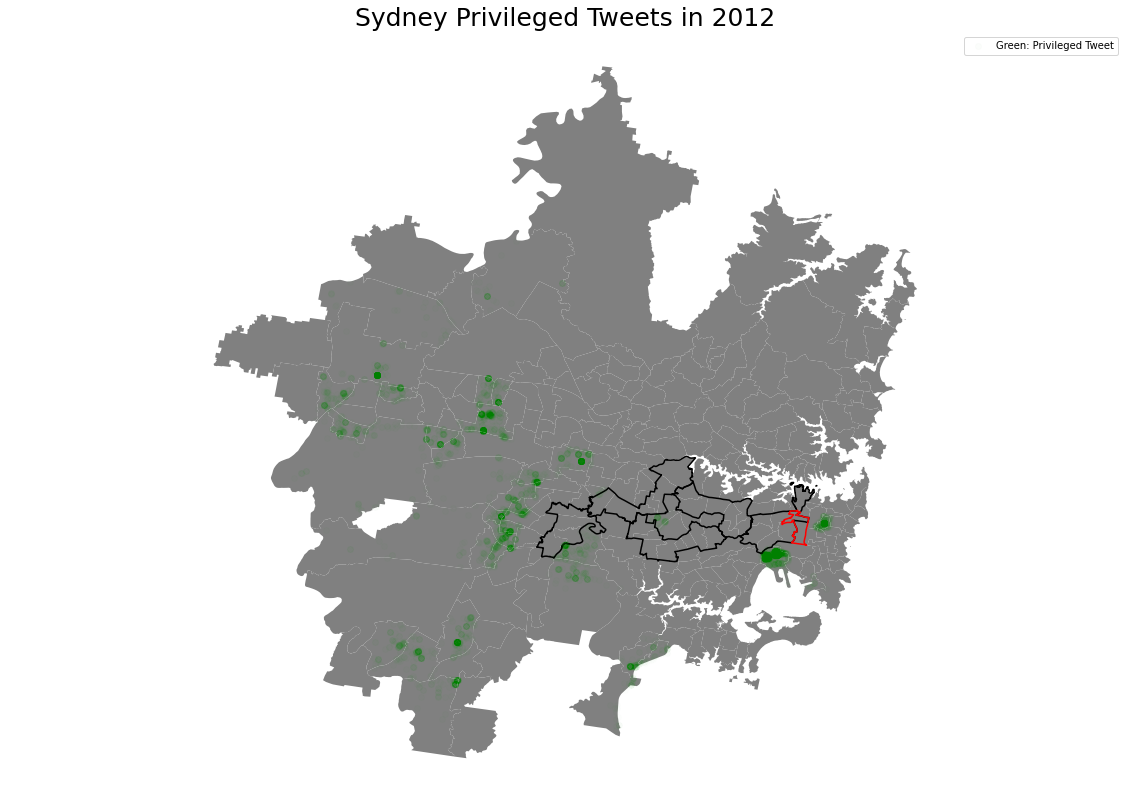

In [88]:
### Plot privileged 2012 tweets where individuals are not in home tract###
# Green tweets: Home tract is "privileged"
fig, ax = plt.subplots(figsize=(20, 14))

base = syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Red", linewidth = 1.5)


twt2012[twt2012['priv_nh_dv']==1].plot(ax=ax, marker='o', color='green', alpha=0.01, label='Green: Privileged Tweet')

plt.legend()

lims=plt.axis('equal')
ax.set_axis_off()

plt.title('Sydney Privileged Tweets in 2012', 
             fontdict={'fontsize':25});

### Plot the distribution of non-outsider tweets from individuals from poor SA2s that are not within their home tract

In [107]:
twt2012['poor_nh_dv'] = np.where(((twt2012.home.notnull())# Where a tract has a home assignment
                              & (twt2012.is_home==0) # Where the tweet is not in their home tract
                              & (twt2012.lowinc_11_dv==1)) # AND their tract is low-income
                              ,1,0)  # return 1 if True, 0 if False

poor_nh_twt_pct = (twt2012['poor_nh_dv'].sum()/len(twt2012))*100

print("A total of", twt2012['poor_nh_dv'].sum(), 
      "/",
      len(twt2012),
      "are from tracts that are poor that are not within their assigned home tract. That equates to approximately",
      round(poor_nh_twt_pct,2),
      "% of all tweets in the year 2012.")

A total of 61457 / 458646 are from tracts that are poor that are not within their assigned home tract. That equates to approximately 13.4 % of all tweets in the year 2012.


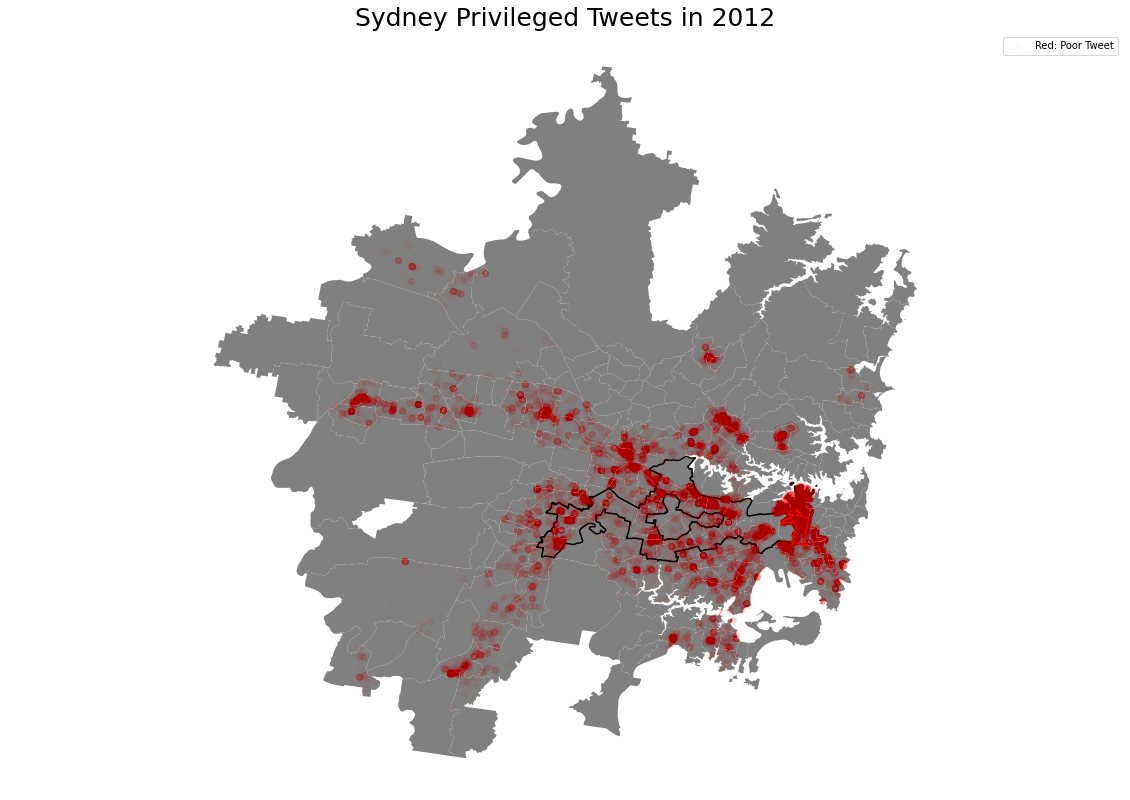

In [96]:
### Plot privileged 2012 tweets where individuals are not in home tract###
# Green tweets: Home tract is "privileged"
fig, ax = plt.subplots(figsize=(20, 14))

base = syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Red", linewidth = 1.5)

twt2012[twt2012['poor_nh_dv']==1].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Poor Tweet')

plt.legend()

lims=plt.axis('equal')
ax.set_axis_off()

plt.title('Sydney Privileged Tweets in 2012', 
             fontdict={'fontsize':25});

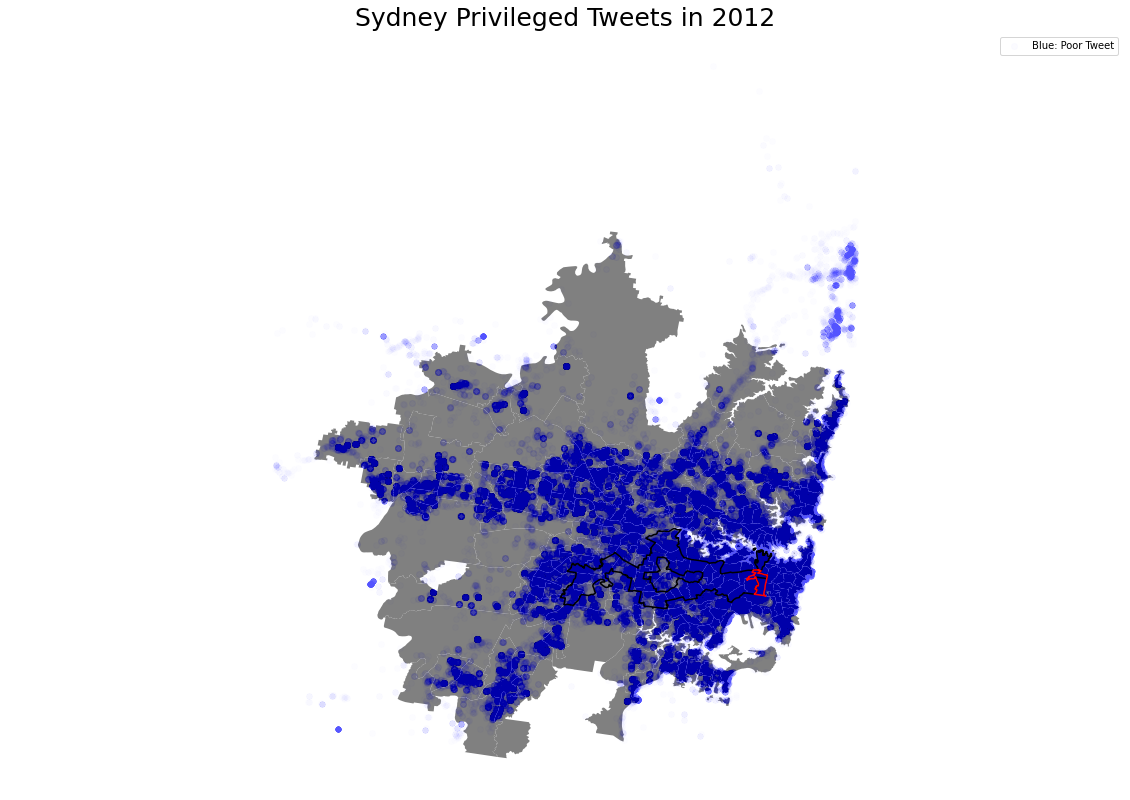

In [99]:
### Plot privileged 2012 tweets where individuals are not in home tract###
# Green tweets: Home tract is "privileged"
fig, ax = plt.subplots(figsize=(20, 14))

base = syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

twt2012[twt2012['poor_nh_dv']==0].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Poor Tweet')

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Red", linewidth = 1.5)

plt.legend()

lims=plt.axis('equal')
ax.set_axis_off()

plt.title('Sydney Privileged Tweets in 2012', 
             fontdict={'fontsize':25});

### Plot the distribution of non-outsider tweets from individuals from highly educated SA2s that are not within their home tract

In [ ]:
# create a dv for individuals from highly educated tracts
twt2012['poor_nh_dv'] = np.where(((twt2012.home.notnull())# Where a tract has a home assignment
                              & (twt2012.is_home==0) # Where the tweet is not in their home tract
                              & (twt2012.bach_11_dv==1)) # AND their tract is highly educated
                              ,1,0)  # return 1 if True, 0 if False

poor_nh_twt_pct = (twt2012['poor_nh_dv'].sum()/len(twt2012))*100

print("A total of", twt2012['poor_nh_dv'].sum(), 
      "/",
      len(twt2012),
      "are from tracts that are poor that are not within their assigned home tract. That equates to approximately",
      round(poor_nh_twt_pct,2),
      "% of all tweets in the year 2012.")

### Build shapes for the above demographic information to create outlines in mapping

In order to properly see the distribution of tweets and whether they were committed into low-income/low educated areas, etc, we need to find out where these places are by creating boundary shapefiles around each area. Let's create simple gdfs out of each one so that we can create maps for each shape. 

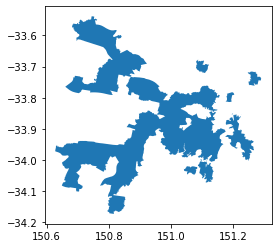

In [26]:
# create polygons for low income areas by merging the shapefile dataframe with the low-income indicator variables
lowinc_shape = pd.merge(syd_ucl_sa2,low_inc,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

# let's isolate the sa2s that make up our that have low-income tracts
lowinc_gdf = lowinc_shape[(lowinc_shape.lowinc_11_dv==1)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
lowinc_simple = lowinc_gdf[['SA2_MAIN16','geometry', "GCC_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
lowinc_sgdf=lowinc_simple.dissolve(by="GCC_NAME16")
lowinc_sgdf.plot()

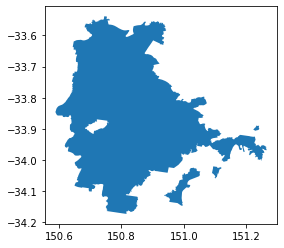

In [28]:
# create polygons for places with high proportion of professionals by merging the shapefile dataframe with the 
# increase in managerial/professional indicator variables
prof_shape = pd.merge(syd_ucl_sa2,prof_delta,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

# let's isolate the sa2s that make up our that have low-income tracts
prof_gdf = prof_shape[(prof_shape.mgr_11_dv==1)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
prof_simple = prof_gdf[['SA2_MAIN16','geometry', "GCC_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
prof_sgdf=prof_simple.dissolve(by="GCC_NAME16")
prof_sgdf.plot()

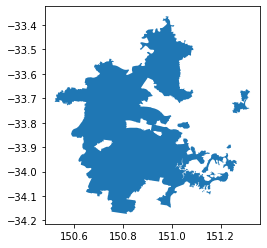

In [31]:
# create polygons for places with high proportion of highly educated people by merging the shapefile dataframe 
# with the bachelor's or higher indicator variables
edu_shape = pd.merge(syd_ucl_sa2,edu_delta,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

# let's isolate the sa2s that make up our that have low-income tracts
edu_gdf = edu_shape[(edu_shape.bach_11_dv==1)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
edu_simple = edu_gdf[['SA2_MAIN16','geometry', "GCC_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
edu_sgdf=edu_simple.dissolve(by="GCC_NAME16")
edu_sgdf.plot()

### Groupby SA2 with tweets that are made within home assignments and outside home assignments

The purpose of this grouping is to get insider vs outsider tweets and to then get view the distrbution along those tweets spatially 

In [32]:
twt2012.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 458646 entries, 0 to 458645
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    458646 non-null  int64         
 1   created_at            458646 non-null  float64       
 2   text                  458646 non-null  object        
 3   u_id                  458646 non-null  int64         
 4   u_created_at          458646 non-null  float64       
 5   type                  458646 non-null  object        
 6   c_country             458646 non-null  object        
 7   geometry              458646 non-null  geometry      
 8   timestamp             458646 non-null  datetime64[ns]
 9   date                  458646 non-null  object        
 10  index_right           450964 non-null  float64       
 11  SA2_MAIN16            450964 non-null  float64       
 12  SA2_5DIG16            450964 non-null  object     

In [56]:
# subset the tweets that do not have a home assignment and classify them as "outsider tweets"
out_twt2012 = twt2012[twt2012.home.isnull()]

# create a groupby statement that groups all of the tweets by SA2 so that we can create a choropleth of the 
# distribution
out_twt2012 = pd.DataFrame(out_twt2012.groupby('SA2_MAIN16')['id'].agg('count'))

# merge the dataframe with the sydney shapefile so that we can add the tweet count column 
out_twt2012 = pd.merge(syd_ucl_sa2,out_twt2012, how='left', on='SA2_MAIN16')
out_twt2012.rename(columns={'id':'tweet_count'},inplace=True)
out_twt2012.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   SA2_MAIN16   265 non-null    int32   
 1   SA2_5DIG16   265 non-null    object  
 2   SA2_NAME16   265 non-null    object  
 3   SA3_CODE16   265 non-null    object  
 4   SA3_NAME16   265 non-null    object  
 5   SA4_CODE16   265 non-null    object  
 6   SA4_NAME16   265 non-null    object  
 7   GCC_CODE16   265 non-null    object  
 8   GCC_NAME16   265 non-null    object  
 9   STE_CODE16   265 non-null    object  
 10  STE_NAME16   265 non-null    object  
 11  AREASQKM16   265 non-null    float64 
 12  geometry     265 non-null    geometry
 13  red_wat_dv   265 non-null    int64   
 14  marrick_dv   265 non-null    int64   
 15  t3_corr_dv   265 non-null    int64   
 16  tweet_count  265 non-null    int64   
dtypes: float64(1), geometry(1), int32(1), int64(4), object(10)
memory

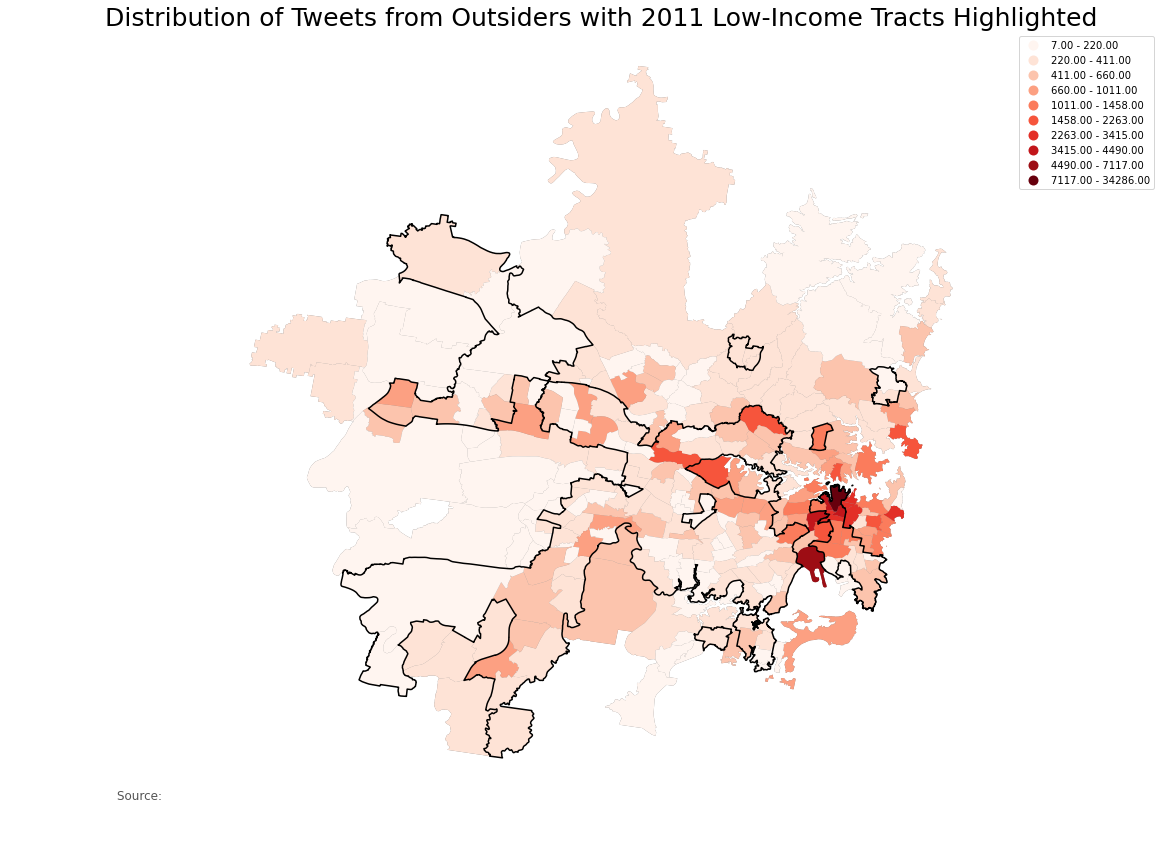

In [58]:
fig, ax = plt.subplots(figsize=(20, 14))
syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')
base = out_twt2012.plot(column="tweet_count", scheme = "fisher_jenks", k = 10, legend=True, ax=ax, cmap="Reds")

lowinc_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)

lims=plt.axis('equal')
ax.set_axis_off()

ax.set_title('Distribution of Tweets from Outsiders with 2011 Low-Income Tracts Highlighted', 
             fontdict={'fontsize':25})

ax.annotate('Source: ',
            xy=(0.1, .08),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, 
            color='#555555')

plt.show()

In [59]:
# subset the tweets that do not have a home assignment and classify them as "outsider tweets"
in_twt2012 = twt2012[twt2012.home.notnull()]

# create a groupby statement that groups all of the tweets by SA2 so that we can create a choropleth of the 
# distribution
in_twt2012 = pd.DataFrame(in_twt2012.groupby('SA2_MAIN16')['id'].agg('count'))

# merge the dataframe with the sydney shapefile so that we can add the tweet count column 
in_twt2012 = pd.merge(syd_ucl_sa2,in_twt2012, how='left', on='SA2_MAIN16')
in_twt2012.rename(columns={'id':'tweet_count'},inplace=True)
in_twt2012.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   SA2_MAIN16   265 non-null    int32   
 1   SA2_5DIG16   265 non-null    object  
 2   SA2_NAME16   265 non-null    object  
 3   SA3_CODE16   265 non-null    object  
 4   SA3_NAME16   265 non-null    object  
 5   SA4_CODE16   265 non-null    object  
 6   SA4_NAME16   265 non-null    object  
 7   GCC_CODE16   265 non-null    object  
 8   GCC_NAME16   265 non-null    object  
 9   STE_CODE16   265 non-null    object  
 10  STE_NAME16   265 non-null    object  
 11  AREASQKM16   265 non-null    float64 
 12  geometry     265 non-null    geometry
 13  red_wat_dv   265 non-null    int64   
 14  marrick_dv   265 non-null    int64   
 15  t3_corr_dv   265 non-null    int64   
 16  tweet_count  265 non-null    int64   
dtypes: float64(1), geometry(1), int32(1), int64(4), object(10)
memory

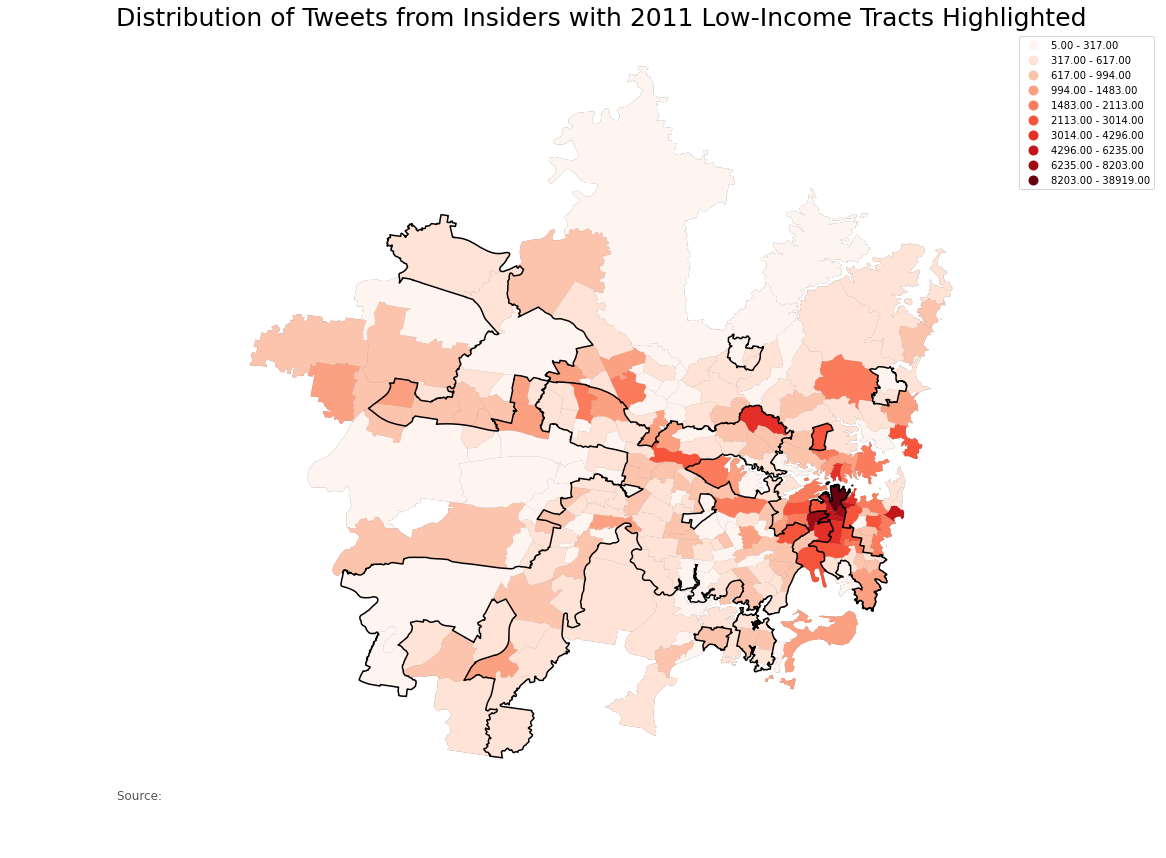

In [60]:
fig, ax = plt.subplots(figsize=(20, 14))
syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')
base = in_twt2012.plot(column="tweet_count", scheme = "fisher_jenks", k = 10, legend=True, ax=ax, cmap="Reds")

lowinc_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)

lims=plt.axis('equal')
ax.set_axis_off()

ax.set_title('Distribution of Tweets from Insiders with 2011 Low-Income Tracts Highlighted', 
             fontdict={'fontsize':25})

ax.annotate('Source: ',
            xy=(0.1, .08),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, 
            color='#555555')

plt.show()

# Saving Output

For future reference, we save an output CSV of all the tweets, spatially joined to the Sydney shapefiles. There are two additional columns:

    home: NaN (missing value) if the tweet user has no home location, else the home tract ('SA2_MAIN16')
    is_home: an indicator (True/False) determining whether home == SA2_MAIN16

In [ ]:
#twt2012.to_csv(data_path/'au_twt2012_joined.csv.gz', index=False, compression='gzip')